# 6주동안의 click_session 데이터 생성
- 2019.10.15 부터 6주 click 데이터
- multiprocessing 활용

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import glob
import os
import pickle

from collections import Counter 

%matplotlib inline

In [ ]:
glob.glob('/mnt/sda1/common/SNU_recommendation/wmind_data/click_data/click_data_6weeks_snu-project/*')

In [3]:
parse_dates = ['serverTime']
#pd.read_csv(file, sep='\t', header=None, names=headers, dtype=dtypes, parse_dates=parse_dates)

data = pd.concat(
    [pd.read_csv(path, parse_dates = parse_dates) for path in glob.glob('/mnt/sda1/common/SNU_recommendation/wmind_data/click_data/click_data_6weeks_snu-project/*')]
, axis=0)

In [4]:
data.head()

,serverTime,mid,pid
0,2019-10-21 04:16:30.172,9404702,602621686
1,2019-10-21 04:16:30.177,7771767,146124413
2,2019-10-21 04:16:30.182,6813096,602614600
3,2019-10-21 04:16:30.227,5471776,602408770
4,2019-10-21 04:16:30.267,17744793,602609603


In [5]:
data.shape

(262456105, 3)

---

### - 상품title null인것들 빼준다...

In [6]:
null_list = [602631866, 602625540, 602467240, 600984871, 600991343]

In [7]:
data = data[~data.pid.isin( null_list )].copy()

---

## # 대략 정보

In [8]:
data.shape

(262455600, 3)

In [9]:
# 약 505개 rows 빠졌다
#262456105-262455600

505

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 262455600 entries, 0 to 7410904
Data columns (total 3 columns):
serverTime    datetime64[ns]
mid           int64
pid           int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 7.8 GB


In [11]:
data.isnull().sum(axis = 0)

serverTime    0
mid           0
pid           0
dtype: int64

In [9]:
data.serverTime.dt.date.nunique() # 맞네 - (서버는 미국시간이라 이렇게 나올 수 있다)

44

In [12]:
# 활동 유저수 - 530만
data.mid.nunique()

5335820

In [13]:
# 6주동안 클릭된 상품 규모 (주문은 96만건)

data.pid.nunique() # 559만개의 상품!

5591911

---

## # 유저들에 대하여

- 유저들의 활동정보

In [9]:
action_ = data.groupby('mid').size().sort_values().reset_index()

In [10]:
action_.shape # 당연히 유저수와 같아야지

(5335820, 2)

In [11]:
action_.columns = ['mid', 'action_count']

In [12]:
action_.head()

,mid,action_count
0,737450143,1
1,2408790,1
2,16536387,1
3,5328448,1
4,26222524,1


In [13]:
# 6주간의 멤버들의 평균 클릭 - 42일간 평균 49회
action_.action_count.mean()

49.1875859755389

In [22]:
action_.action_count.describe() # 오른쪽 긴 꼬리 형태 : (평균 49) 중위수 10 / 상위 25% - 40 /  더 살펴보자...

count    5.335820e+06
mean     4.918759e+01
std      1.175592e+02
min      1.000000e+00
25%      3.000000e+00
50%      1.000000e+01
75%      4.000000e+01
max      1.181600e+04
Name: action_count, dtype: float64

In [25]:
action_.quantile(0.8)

mid             21946184.2
action_count          57.0
Name: 0.8, dtype: float64

In [26]:
action_.quantile(0.85)

mid             24233921.3
action_count          84.0
Name: 0.85, dtype: float64

In [27]:
action_.quantile(0.9)

mid             26536416.1
action_count         131.0
Name: 0.9, dtype: float64

In [28]:
action_.quantile(0.95) # 상위 5%인 애의 클릭빈도가 232회인데

mid             29425319.8
action_count         232.0
Name: 0.95, dtype: float64

(0, 100)

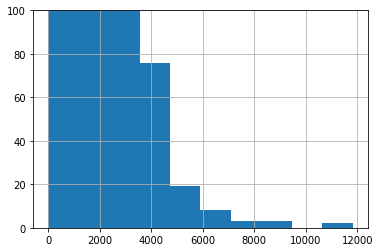

In [32]:
action_.action_count.hist()
plt.ylim(0,100)

### - over-active 유저
- 이들을 제거해야하나?

In [43]:
print('over_active user count : {}'.format( action_[action_.action_count > 1600].shape[0]) )
print('over_active user ratio : {}'.format( action_[action_.action_count > 1600].shape[0]/action_.shape[0] ) )

over_active user count : 2122
over_active user ratio : 0.00039768957723461434


In [38]:
action_[action_.action_count > 1600].mid.sample(10)

5335596    29187027
5334249    21989978
5333999     7606725
5335015    25905166
5335674    21277648
5335160    23151703
5335644    25480044
5335713     6329574
5334566    22905128
5333753    12844306
Name: mid, dtype: int64

In [41]:
# case 1

print( data[data.mid == 29187027].shape[0] )
print( data[data.mid == 29187027].serverTime.dt.date.nunique() )

2890
44


In [44]:
data[data.mid == 29187027]

,serverTime,mid,pid
336129,2019-10-21 05:31:58.854,29187027,601994496
340350,2019-10-21 05:32:50.158,29187027,152845139
405761,2019-10-21 05:47:01.728,29187027,159165492
678391,2019-10-21 06:50:59.472,29187027,244228469
735303,2019-10-21 07:04:44.745,29187027,244228469
...,...,...,...
7399638,2019-11-04 10:23:31.891,29187027,602644064
7400094,2019-11-04 10:23:36.651,29187027,600156695
7403944,2019-11-04 10:24:17.497,29187027,155369330
7408711,2019-11-04 10:25:05.958,29187027,147137842


In [45]:
data[data.mid == 29187027].pid.nunique()

550

In [ ]:
### 음.. 일단 그냥간다

---

### # timediff
- 시간별 sorting, index 초기화
- 멤버별로 클릭의 time-diff 구한다

In [14]:
data.head()

,serverTime,mid,pid
0,2019-10-21 04:16:30.172,9404702,602621686
1,2019-10-21 04:16:30.177,7771767,146124413
2,2019-10-21 04:16:30.182,6813096,602614600
3,2019-10-21 04:16:30.227,5471776,602408770
4,2019-10-21 04:16:30.267,17744793,602609603


In [10]:
# 시간별 sorting, index 초기화
data_re = data.sort_values(by='serverTime', ascending=True).reset_index(drop=True).copy()

In [10]:
data_re

,serverTime,mid,pid
0,2019-10-15 00:00:00.003,1628926,152823017
1,2019-10-15 00:00:00.006,18507518,602597344
2,2019-10-15 00:00:00.010,21346403,189973551
3,2019-10-15 00:00:00.035,10969804,287406027
4,2019-10-15 00:00:00.105,1040863,139844404
...,...,...,...
262455595,2019-11-27 23:59:59.847,6714226,153271286
262455596,2019-11-27 23:59:59.854,30209610,602674375
262455597,2019-11-27 23:59:59.879,2349455,602309929
262455598,2019-11-27 23:59:59.925,13180560,155071189


---

### - mid 별로, time_diff 구한다
- mid 그룹 30등분하여 multiprocessing

In [11]:
mid_list = data_re.mid.unique().tolist()

In [12]:
# seq를 비슷하게 나눠주는 함수 - mid 30등분

def chunkify(lst,n):
    return [lst[i::n] for i in range(n)]

In [16]:
mid_chunk = chunkify(mid_list, 30)

In [17]:
len(mid_chunk)

30

In [18]:
# mid 별로 데이터 쪼갠다
tmp = data_re.copy() # 초기화
data_split_l = []

for chunk in mid_chunk:
    data_split_l.append( tmp[tmp.mid.isin(chunk)] )
    tmp = tmp[ ~ tmp.mid.isin(chunk)]

In [19]:
data_split_l[0]

,serverTime,mid,pid
0,2019-10-15 00:00:00.003,1628926,152823017
30,2019-10-15 00:00:00.782,7959462,126897501
60,2019-10-15 00:00:01.304,1112783,602405952
90,2019-10-15 00:00:01.978,3096819,205115419
120,2019-10-15 00:00:02.637,19181308,602166255
...,...,...,...
262455373,2019-11-27 23:59:56.195,29896218,601243237
262455445,2019-11-27 23:59:57.468,15681444,600112820
262455458,2019-11-27 23:59:57.623,13764180,600086234
262455486,2019-11-27 23:59:58.037,1308601,310514479


In [24]:
chunk_size = 0
for split in data_split_l:
    print(split.shape[0])
    chunk_size += split.shape[0]

8810176
8776742
8803148
8762736
8847707
8775443
8721148
8724261
8695891
8806524
8681589
8743143
8677777
8731982
8745555
8764965
8764892
8765815
8758212
8764706
8673545
8715430
8744533
8791849
8749574
8627906
8727120
8747272
8725057
8830902


---

- eg. 이런식으로 하면 된다

In [28]:
data_split_l[0]

,serverTime,mid,pid
0,2019-10-15 00:00:00.003,1628926,152823017
30,2019-10-15 00:00:00.782,7959462,126897501
60,2019-10-15 00:00:01.304,1112783,602405952
90,2019-10-15 00:00:01.978,3096819,205115419
120,2019-10-15 00:00:02.637,19181308,602166255
...,...,...,...
262455373,2019-11-27 23:59:56.195,29896218,601243237
262455445,2019-11-27 23:59:57.468,15681444,600112820
262455458,2019-11-27 23:59:57.623,13764180,600086234
262455486,2019-11-27 23:59:58.037,1308601,310514479


In [29]:
data_split_l[0][data_split_l[0].mid == 1628926]

,serverTime,mid,pid
0,2019-10-15 00:00:00.003,1628926,152823017
1263,2019-10-15 00:00:27.209,1628926,180751751
4147,2019-10-15 00:01:26.492,1628926,152823017
126536,2019-10-15 00:39:44.817,1628926,602595601
144962,2019-10-15 00:45:02.689,1628926,602609862
...,...,...,...
255863053,2019-11-26 18:20:13.066,1628926,600053630
255864442,2019-11-26 18:21:04.446,1628926,313826296
255866042,2019-11-26 18:22:06.383,1628926,600053630
255870174,2019-11-26 18:24:45.402,1628926,602686749


In [35]:
tmp = data_split_l[0].copy()

In [36]:
tmp

,serverTime,mid,pid
0,2019-10-15 00:00:00.003,1628926,152823017
30,2019-10-15 00:00:00.782,7959462,126897501
60,2019-10-15 00:00:01.304,1112783,602405952
90,2019-10-15 00:00:01.978,3096819,205115419
120,2019-10-15 00:00:02.637,19181308,602166255
...,...,...,...
262455373,2019-11-27 23:59:56.195,29896218,601243237
262455445,2019-11-27 23:59:57.468,15681444,600112820
262455458,2019-11-27 23:59:57.623,13764180,600086234
262455486,2019-11-27 23:59:58.037,1308601,310514479


In [37]:
tmp.sort_values(by=['mid', 'serverTime'], inplace=True)

In [38]:
tmp

,serverTime,mid,pid
10769473,2019-10-17 05:42:29.474,1000113,312701141
12845710,2019-10-17 14:49:18.287,1000157,221334540
12858922,2019-10-17 14:52:08.932,1000157,221334540
12859869,2019-10-17 14:52:21.944,1000157,221334540
12874522,2019-10-17 14:55:34.932,1000157,251146845
...,...,...,...
262154883,2019-11-27 22:28:16.121,30754704,289212571
262167928,2019-11-27 22:32:58.720,30754704,289212571
262177493,2019-11-27 22:36:19.989,30754704,295220963
262157714,2019-11-27 22:29:17.938,30754711,602620808


In [33]:
tmp[tmp.mid == 1628926]

,serverTime,mid,pid
0,2019-10-15 00:00:00.003,1628926,152823017
1263,2019-10-15 00:00:27.209,1628926,180751751
4147,2019-10-15 00:01:26.492,1628926,152823017
126536,2019-10-15 00:39:44.817,1628926,602595601
144962,2019-10-15 00:45:02.689,1628926,602609862
...,...,...,...
255863053,2019-11-26 18:20:13.066,1628926,600053630
255864442,2019-11-26 18:21:04.446,1628926,313826296
255866042,2019-11-26 18:22:06.383,1628926,600053630
255870174,2019-11-26 18:24:45.402,1628926,602686749


In [71]:
time_diff = tmp.groupby('mid')['serverTime'].diff()

In [72]:
time_diff

10769473                NaT
12845710                NaT
12858922    00:02:50.645000
12859869    00:00:13.012000
12874522    00:03:12.988000
                  ...      
262154883   00:01:43.412000
262167928   00:04:42.599000
262177493   00:03:21.269000
262157714               NaT
216602207               NaT
Name: serverTime, Length: 8810176, dtype: timedelta64[ns]

In [73]:
data_w_tdiff = tmp.merge(time_diff, left_index=True, right_index=True)

In [74]:
data_w_tdiff

,serverTime_x,mid,pid,serverTime_y
10769473,2019-10-17 05:42:29.474,1000113,312701141,NaT
12845710,2019-10-17 14:49:18.287,1000157,221334540,NaT
12858922,2019-10-17 14:52:08.932,1000157,221334540,00:02:50.645000
12859869,2019-10-17 14:52:21.944,1000157,221334540,00:00:13.012000
12874522,2019-10-17 14:55:34.932,1000157,251146845,00:03:12.988000
...,...,...,...,...
262154883,2019-11-27 22:28:16.121,30754704,289212571,00:01:43.412000
262167928,2019-11-27 22:32:58.720,30754704,289212571,00:04:42.599000
262177493,2019-11-27 22:36:19.989,30754704,295220963,00:03:21.269000
262157714,2019-11-27 22:29:17.938,30754711,602620808,NaT


In [77]:
time_diff.columns = ['time_diff']

In [83]:
time_diff.name

'serverTime'

In [78]:
pd.concat([tmp,time_diff], axis=1)

,serverTime,mid,pid,serverTime
10769473,2019-10-17 05:42:29.474,1000113,312701141,NaT
12845710,2019-10-17 14:49:18.287,1000157,221334540,NaT
12858922,2019-10-17 14:52:08.932,1000157,221334540,00:02:50.645000
12859869,2019-10-17 14:52:21.944,1000157,221334540,00:00:13.012000
12874522,2019-10-17 14:55:34.932,1000157,251146845,00:03:12.988000
...,...,...,...,...
262154883,2019-11-27 22:28:16.121,30754704,289212571,00:01:43.412000
262167928,2019-11-27 22:32:58.720,30754704,289212571,00:04:42.599000
262177493,2019-11-27 22:36:19.989,30754704,295220963,00:03:21.269000
262157714,2019-11-27 22:29:17.938,30754711,602620808,NaT


---

### - 분산처리

In [20]:
import multiprocessing

In [21]:
num_cores = 30

In [22]:
def parallelize_dataframe(df_split, func):
    #
    pool = multiprocessing.Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df



In [29]:
def make_sess(data):
    data_ = data.sort_values(by=['mid','serverTime']).copy()
    time_diff = data_.groupby('mid')['serverTime'].diff()
    data_w_tdiff = data_.merge(time_diff, left_index=True, right_index=True) # 'serverTime_y'가 생겼다
    
    #using data_w_tdiff -> make session
    # *원래 time_diff 의 fillna는 0으로 해도 되었는데, 이제 이렇게 Timedelta형식으로 채워야한다.
    data_w_tdiff.fillna( pd.Timedelta(seconds=0), inplace=True) # 유저의 시작점(time_diff의) 0으로 채워주자
    
    n=0
    session = []
    for diff in data_w_tdiff['serverTime_y']:
        if diff == pd.to_timedelta('0'): 
            session.append(n)
            n+=1
        elif diff > pd.to_timedelta('01:00:00'):
            session.append(n)
            n+=1
        else:
            session.append(n-1)
    data_w_tdiff['session'] = session
    
    return data_w_tdiff

In [27]:
len(data_split_l)

30

In [28]:
%%time
data_session_parallel = parallelize_dataframe( data_split_l, make_sess )

CPU times: user 24.4 s, sys: 53.2 s, total: 1min 17s
Wall time: 7min 52s


In [30]:
len(data_session_parallel)

262455600

In [32]:
data_session_parallel.head()

,serverTime_x,mid,pid,serverTime_y,session
10769473,2019-10-17 05:42:29.474,1000113,312701141,00:00:00,0
12845710,2019-10-17 14:49:18.287,1000157,221334540,00:00:00,1
12858922,2019-10-17 14:52:08.932,1000157,221334540,00:02:50.645000,1
12859869,2019-10-17 14:52:21.944,1000157,221334540,00:00:13.012000,1
12874522,2019-10-17 14:55:34.932,1000157,251146845,00:03:12.988000,1


In [ ]:
session_list = [sess[1].drop_duplicates().tolist() for sess in data_session_parallel.groupby(['mid', 'session'])['pid']]

In [ ]:
#### session 저장
with open('session_lisit', 'wb') as f:
    pickle.dump(tmp_sess, f) 

---

In [2]:
# pkl 로드하여 사용할때
#with open('tmp_sess_1206', 'rb') as f:
#    tmp_sess = pickle.load(f)

In [4]:
tmp_sess = session_list
len(tmp_sess)

60746812

In [5]:
graph_list = []
for k in range(len(tmp_sess)):
    for i in range(len(tmp_sess[k])-1):
        graph_list.append( (tmp_sess[k][i], tmp_sess[k][i+1]) )

In [6]:
len(graph_list) # 6주 - 1억5천개의 edge

151916990

In [ ]:
i

In [9]:
# 그래프 이렇게 다시 만들어야해!
graph_list = [(x, y, {'weight': v}) for (x, y), v in Counter(graph_list).items()]

In [10]:
len(graph_list) # edge유형이 6천 800만이네..! 좀 많네

68497234

In [11]:
with open('graph_list_1206', 'wb') as f:
    pickle.dump(graph_list, f)

# 여기까지 작업
---
---
---